In [1]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import re

In [2]:
def read(file):
    with open(file, 'r') as file:
        return file.readlines()

def parse_line(line):
    pattern = re.compile(r'(?P<Date>\d{6})\s+(?P<Time>\d{6})\s+(?P<Pid>\d+)\s+(?P<Level>[A-Z]+)\s+(?P<Component>[\w.$]+):\s+(?P<Content>.+)')
    format = pattern.match(line)
    if format:
        return format.groupdict()
    return None

def convert_to_csv(log_file, csv_file):
    attrbts = ["Date", "Time", "Pid", "Level", "Component", "Content"]
    log_lines = read(log_file) # list[] of log lines
    prsd_logs = [parse_line(line) for line in log_lines] #dictionary of all log lines with entries
    prsd_logs = [entry for entry in prsd_logs if entry] #filtering out None entries

    df = pd.DataFrame(prsd_logs, columns=attrbts)
    df.to_csv(csv_file, index=False)

In [3]:
log_file = 'HDFS_Logs.log'
csv_file = 'HDFS_struc-logs.csv'
convert_to_csv(log_file, csv_file)

In [4]:
df = pd.read_csv(csv_file)
df.head()

,Date,Time,Pid,Level,Component,Content
0,81109,203615,148,INFO,dfs.DataNode$PacketResponder,PacketResponder 1 for block blk_38865049064139...
1,81109,203807,222,INFO,dfs.DataNode$PacketResponder,PacketResponder 0 for block blk_-6952295868487...
2,81109,204005,35,INFO,dfs.FSNamesystem,BLOCK* NameSystem.addStoredBlock: blockMap upd...
3,81109,204015,308,INFO,dfs.DataNode$PacketResponder,PacketResponder 2 for block blk_82291938032499...
4,81109,204106,329,INFO,dfs.DataNode$PacketResponder,PacketResponder 2 for block blk_-6670958622368...


In [5]:
df.shape

(2000, 6)

In [6]:
dup_rows = df[df.duplicated()]
print("Duplicate Rows: ", dup_rows.shape)
# checking for duplicate rows

Duplicate Rows:  (0, 6)


In [7]:
print(df.isnull().sum())
#checking for missing values

Date         0
Time         0
Pid          0
Level        0
Component    0
Content      0
dtype: int64


In [8]:
df['Level'].value_counts()

Level
INFO    1920
WARN      80
Name: count, dtype: int64

In [9]:
df['Content']

0       PacketResponder 1 for block blk_38865049064139...
1       PacketResponder 0 for block blk_-6952295868487...
2       BLOCK* NameSystem.addStoredBlock: blockMap upd...
3       PacketResponder 2 for block blk_82291938032499...
4       PacketResponder 2 for block blk_-6670958622368...
                              ...                        
1995    Receiving block blk_4198733391373026104 src: /...
1996    Received block blk_-5815145248455404269 of siz...
1997    Receiving block blk_-295306975763175640 src: /...
1998    PacketResponder 0 for block blk_52257196770490...
1999    Receiving block blk_4343207286455274569 src: /...
Name: Content, Length: 2000, dtype: object

In [10]:
def assign_event_temp(df):
    event_temps = []
    
    patterns = {
        'PacketResponder': re.compile(r'PacketResponder \d+ for block blk_[-]?\d+ terminating'),
        'StoredBlock': re.compile(r'BLOCK\* NameSystem\.addStoredBlock: blockMap updated: \d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}:\d+ is added to blk_[-]?\d+ size \d+'),
        'ReceivedBlock': re.compile(r'Received block blk_[-]?\d+ of size \d+ from /\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}'),
        'ReceivingBlock': re.compile(r'Receiving block blk_[-]?\d+ src: /[\d\.]+:\d+ dest: /[\d\.]+:\d+'),
        'Verification': re.compile(r'Verification succeeded for blk_[-]?\S+'),
        'AllocateBlock': re.compile(r'BLOCK\* NameSystem\.allocateBlock: [^\s]+\. blk_[-]?\S+'),
        'DeletingBlockWithFile': re.compile(r'Deleting block blk_[-]?\d+ file /[^\s]+ blk_[-]?\d+'),
        'DeletingBlockWithoutFile': re.compile(r'Deleting block blk_[-]?\d+ file /[^\s]+'),
        'ServedBlock': re.compile(r'\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}:\d+ Served block blk_[-]?\S+ to /\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}'),
        'Exception': re.compile(r'\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}:\d+:Got exception while serving blk_[-]?\S+ to /\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}:'),
        'InvalidSet': re.compile(r'BLOCK\* NameSystem\.delete: blk_[-]?\d+ is added to invalidSet of \d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}:\d+'),
        'MultipleDelete': re.compile(r'BLOCK\* ask \d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}:\d+ to delete (blk_[-]?\d+ )+'),
        'TransferBlock': re.compile(r'\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}:\d+ Starting thread to transfer block blk_[-]?\d+ to \d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}:\d+'),
        'SingleBlockDelete': re.compile(r'BLOCK\* ask \d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}:\d+ to delete blk_[-]?\d+'),
        'ReceivedBlockWithDest': re.compile(r'Received block blk_[-]?\d+ src: /\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}:\d+ dest: /\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}:\d+ of size \d+'),
        'MultipleDeleteExtended': re.compile(r'BLOCK\* ask \d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}:\d+ to delete ((blk_[-]?\d+)(\s|$))+'),
        'Replication': re.compile(r'BLOCK\* ask \d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}:\d+ to replicate blk_[-]?\d+ to datanode\(s\) \d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}:\d+')
    }

    temp_map = {
        'PacketResponder': 'PacketResponder <*> for block blk_<*> terminating',
        'StoredBlock': 'BLOCK* NameSystem.addStoredBlock: blockMap updated: <*>:<*> is added to blk_<*> size <*>',
        'ReceivedBlock': 'Received block blk_<*> of size <*> from /<*>',
        'ReceivingBlock': 'Receiving block blk_<*> src: /<*>:<*> dest: /<*>:<*>',
        'Verification': 'Verification succeeded for blk_<*>',
        'AllocateBlock': 'BLOCK* NameSystem.allocateBlock: <*>. blk_<*>',
        'DeletingBlockWithFile': 'Deleting block blk_<*> file /<*> blk_<*>',
        'DeletingBlockWithoutFile': 'Deleting block blk_<*> file /<*>',
        'ServedBlock': '<*> Served block blk_<*> to /<*>',
        'Exception': '<*>:Got exception while serving blk_<*> to /<*>:',
        'InvalidSet': 'BLOCK* NameSystem.delete: blk_<*> is added to invalidSet of <*>:<*>',
        'MultipleDelete': 'BLOCK* ask <*> to delete blk_<*>',
        'TransferBlock': '<*> Starting thread to transfer block blk_<*> to <*>:<*>',
        'SingleBlockDelete': 'BLOCK* ask <*>:<*> to delete blk_<*>',
        'ReceivedBlockWithDest': 'Received block blk_<*> src: /<*>:<*> dest: /<*>:<*> of size <*>',
        'MultipleDeleteExtended': 'BLOCK* ask <*>:<*> to delete blk_<*>',
        'Replication': 'BLOCK* ask <*>:<*> to replicate blk_<*> to datanode(s) <*>:<*>'
    }
    
    for content in df['Content']:
        match = False
        for key, ptrn in patterns.items():
            if ptrn.match(content):
                event_temps.append(temp_map[key])
                match = True
                break
        if not match:
            event_temps.append('Unknown Event Type')
    
    df['EventTemplate'] = event_temps
    return df

def assign_event_ids(df):
    event_ids = {
        'PacketResponder <*> for block blk_<*> terminating': 'E50',
        'BLOCK* NameSystem.addStoredBlock: blockMap updated: <*>:<*> is added to blk_<*> size <*>': 'E60',
        'Received block blk_<*> of size <*> from /<*>': 'E30',  
        'Receiving block blk_<*> src: /<*>:<*> dest: /<*>:<*>': 'E20',  
        'Verification succeeded for blk_<*>': 'E10',  
        'BLOCK* NameSystem.allocateBlock: <*>. blk_<*>': 'E40',  
        'Deleting block blk_<*> file /<*> blk_<*>': 'E70',  
        'Deleting block blk_<*> file /<*>': 'E70',  
        '<*> Served block blk_<*> to /<*>': 'E60',  
        '<*>:Got exception while serving blk_<*> to /<*>:': 'E80',  
        'BLOCK* NameSystem.delete: blk_<*> is added to invalidSet of <*>:<*>': 'E90',  
        'BLOCK* ask <*> to delete blk_<*>': 'E90',  
        '<*> Starting thread to transfer block blk_<*> to <*>:<*>': 'E20',  
        'Received block blk_<*> src: /<*>:<*> dest: /<*>:<*> of size <*>': 'E20',
        'BLOCK* ask <*>:<*> to delete blk_<*>': 'E90',  
        'BLOCK* ask <*>:<*> to replicate blk_<*> to datanode(s) <*>:<*>': 'E30'  
    }
    
    df['EventID'] = df['EventTemplate'].map(event_ids).fillna('E99')
    
    return df

In [11]:
df = assign_event_temp(df)
df = assign_event_ids(df)
df.to_csv('HDFS_struc-logs.csv', index=False)

/var/folders/fm/q8cv3x_1785fdy_vjj0_67qh0000gn/T/ipykernel_75667/4197322981.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='EventID', data=df, order=df['EventID'].value_counts().index, palette='viridis')


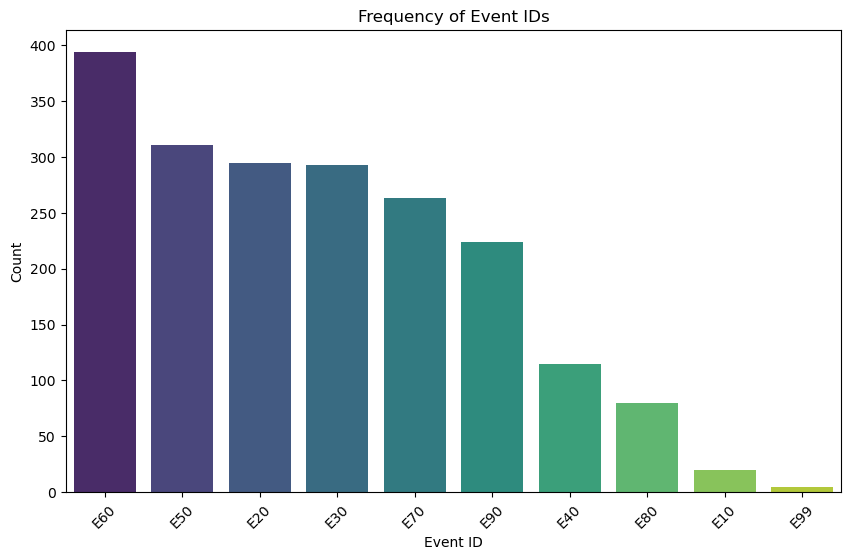

In [12]:
plt.figure(figsize=(10, 6))
sns.countplot(x='EventID', data=df, order=df['EventID'].value_counts().index, palette='viridis')
plt.title('Frequency of Event IDs')
plt.xlabel('Event ID')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

/var/folders/fm/q8cv3x_1785fdy_vjj0_67qh0000gn/T/ipykernel_75667/3607844224.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='EventType', data=df, order=df['EventType'].value_counts().index, palette='Set2')


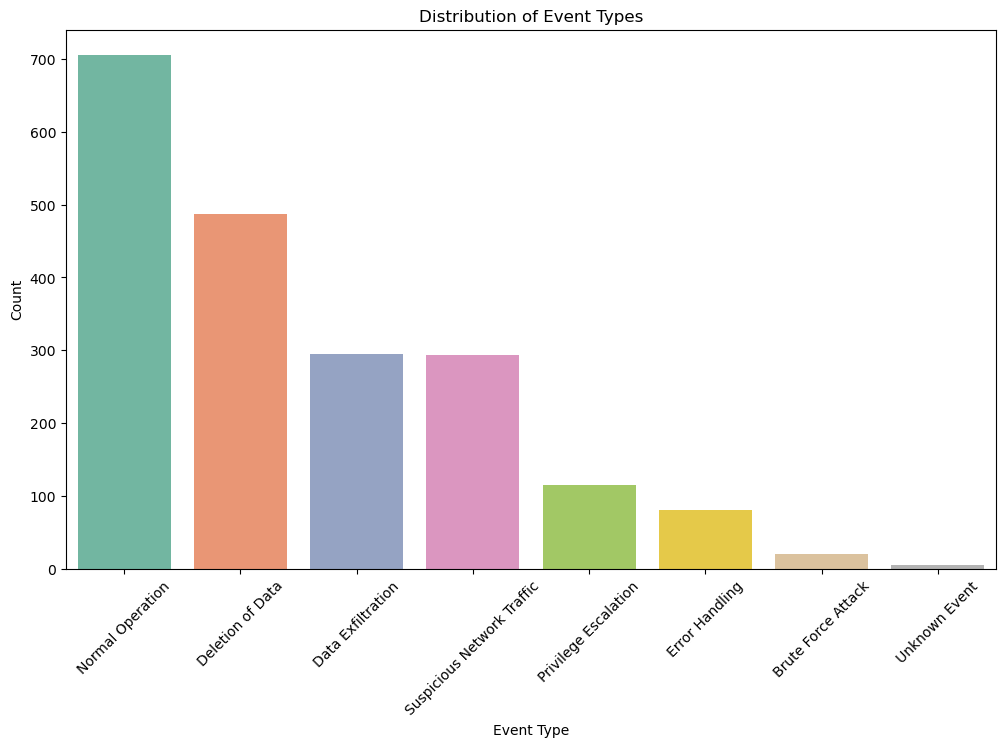

In [13]:
df['EventType'] = df['EventID'].map({
    'E10': 'Brute Force Attack',
    'E20': 'Data Exfiltration',
    'E30': 'Suspicious Network Traffic',
    'E40': 'Privilege Escalation',
    'E50': 'Normal Operation',
    'E60': 'Normal Operation',
    'E70': 'Deletion of Data',
    'E80': 'Error Handling',
    'E90': 'Deletion of Data',
    'E99': 'Unknown Event'
})

plt.figure(figsize=(12, 7))
sns.countplot(x='EventType', data=df, order=df['EventType'].value_counts().index, palette='Set2')
plt.title('Distribution of Event Types')
plt.xlabel('Event Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

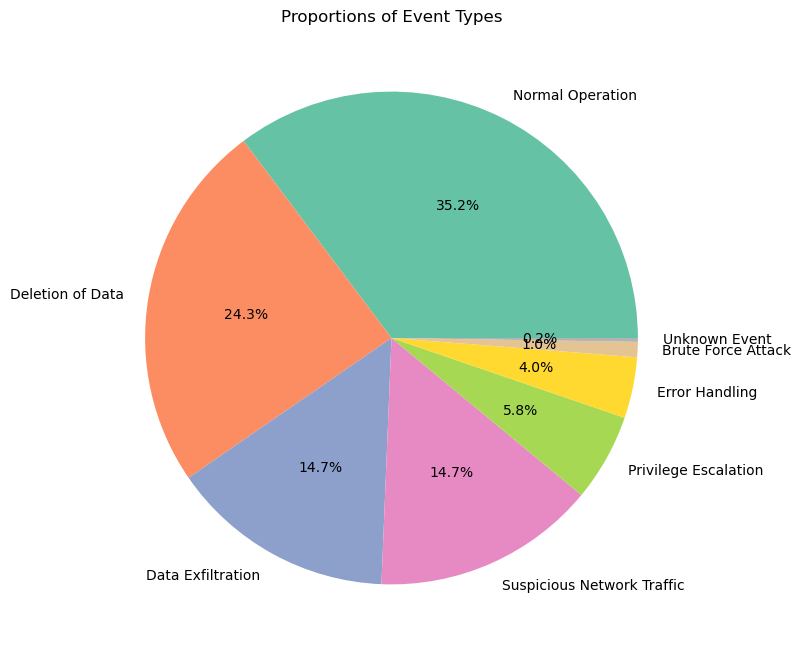

In [14]:
# Pie chart for Event Type Proportions
count = df['EventType'].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(count, labels=count.index, autopct='%1.1f%%', colors=sns.color_palette('Set2', len(count)))
plt.title('Proportions of Event Types')
plt.show()

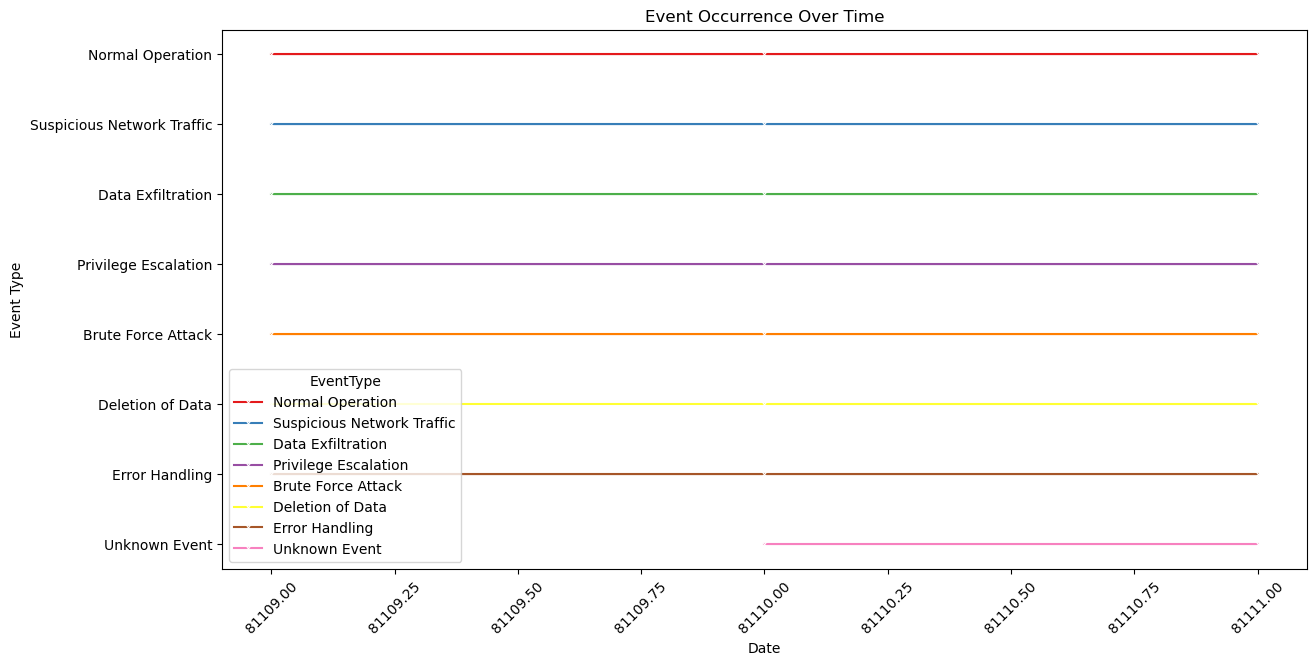

In [15]:
#Line plot for Event Occurrence Over Time
plt.figure(figsize=(14, 7))
sns.lineplot(x='Date', y='EventType', data=df, hue='EventType', palette='Set1', marker='x')
plt.title('Event Occurrence Over Time')
plt.xlabel('Date')
plt.ylabel('Event Type')
plt.xticks(rotation=45)
plt.show()

In [16]:
def detect_event(df, event_id):
    for index, row in df.iterrows():
        if event_id in row['EventID']:
            return index, row
    return None, None

def handle_event(id, event):
    idx, et_row = detect_event(df, id)
    if et_row is not None:
        print(f"\n{event} Detected")
        while True:
            print("\nWhat do you want to do?")
            print("1. View Event Details")
            print("2. Do Nothing")
            ch = input("Enter your choice: ")
            if ch == '1':
                print(f"\nEvent Details for {event} at Index {idx}:")
                print(et_row.to_string())
                print("-" * 40)
                break
            elif ch == '2':
                print("No Action Taken\n")
                break
            else:
                print("Invalid choice, please select again.")

        rps = input("Do you want to scan for more events? (y/n): ")
        if rps != 'y':
            print("Stopping the scan.")
            return False
    else:
        print(f"No {event} Detected\n")
    return True

events = [
    ('E10', "Brute Force Attack"),
    ('E20', "Data Exfiltration"),
    ('E30', "Suspicious Network Traffic"),
    ('E40', "Privilege Escalation"),
    ('E70|E90', "Deletion of Data"),
    ('E80', "Error Handling"),
    ('E99', "Unknown Event"),
    ('E50|E60', "Normal Operation")
]

for ev_id, ev_nm in events:
    if not handle_event(ev_id, ev_nm):
        break


Brute Force Attack Detected

What do you want to do?
1. View Event Details
2. Do Nothing

Event Details for Brute Force Attack at Index 28:
Date                                                         81109
Time                                                        205931
Pid                                                             13
Level                                                         INFO
Component                                     dfs.DataBlockScanner
Content          Verification succeeded for blk_-49809165198942...
EventTemplate                   Verification succeeded for blk_<*>
EventID                                                        E10
EventType                                       Brute Force Attack
----------------------------------------

Data Exfiltration Detected

What do you want to do?
1. View Event Details
2. Do Nothing
No Action Taken

Stopping the scan.
